# 统计学
:label:`sec_statistics`

毫无疑问，要成为一名顶尖的深度学习实践者，训练最先进且高精度的模型的能力至关重要。然而，通常不清楚改进是显著的，还是仅仅是训练过程中的随机波动的结果。为了能够讨论估计值的不确定性，我们必须学习一些统计学知识。

*统计学*的最早记载可以追溯到9世纪的阿拉伯学者Al-Kindi，他详细描述了如何使用统计学和频率分析来解密加密信息。800年后，现代统计学在18世纪的德国兴起，当时的研究人员专注于人口和经济数据的收集和分析。如今，统计学是一门关于数据收集、处理、分析、解释和可视化的科学学科。更重要的是，统计学的核心理论已在学术界、工业界和政府的研究中得到广泛应用。

更具体地说，统计学可以分为*描述统计学*和*统计推断*。前者侧重于总结和说明观察数据集合（称为*样本*）的特征。样本是从*总体*中抽取的，表示我们实验兴趣的全部相似个体、项目或事件的集合。与描述统计学相反，*统计推断*进一步基于样本分布可以在某种程度上复制总体分布的假设，从给定的*样本*中推断出总体的特征。

你可能会问：“机器学习和统计学的本质区别是什么？”从根本上说，统计学关注的是推断问题。这类问题包括变量之间关系的建模，例如因果推断，以及测试模型参数的统计显著性，例如A/B测试。相比之下，机器学习强调做出准确预测，而不需要明确编程和理解每个参数的功能。

在本节中，我们将介绍三种类型的统计推断方法：评估和比较估计量、进行假设检验以及构建置信区间。这些方法可以帮助我们推断给定总体的特征，即真实参数$\theta$。为简洁起见，我们假设给定总体的真实参数$\theta$是一个标量值。将$\theta$扩展为向量或张量的情况是直接的，因此我们在讨论中省略了这一点。



## 评估和比较估计量

在统计学中，*估计量*是用于估计真实参数$\theta$的给定样本的函数。我们将写$\hat{\theta}_n = \hat{f}(x_1, \ldots, x_n)$来表示在观察到样本{$x_1, x_2, \ldots, x_n$}之后对$\theta$的估计。

我们在:numref:`sec_maximum_likelihood`一节中已经看到了简单的估计量例子。如果你有一些来自伯努利随机变量的样本，那么通过计算观察到的1的数量并除以总样本数，可以获得该随机变量为1的概率的最大似然估计。同样，一个练习要求你证明给定一些样本时高斯均值的最大似然估计是由所有样本的平均值给出的。这些估计量几乎永远不会给出参数的真实值，但理想情况下，对于大量样本，估计值会很接近。

例如，我们在下面展示了均值为零、方差为一的高斯随机变量的真实密度，以及从该高斯分布中抽取的一组样本。我们构造了$y$坐标，使每个点都可见，并且与原始密度的关系更清晰。

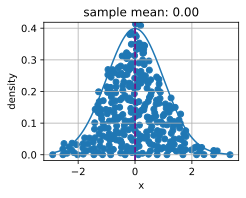

In [1]:
import torch
from d2l import torch as d2l

torch.pi = torch.acos(torch.zeros(1)) * 2  #define pi in torch

# Sample datapoints and create y coordinate
epsilon = 0.1
torch.manual_seed(8675309)
xs = torch.randn(size=(300,))

ys = torch.tensor(
    [torch.sum(torch.exp(-(xs[:i] - xs[i])**2 / (2 * epsilon**2))\
               / torch.sqrt(2*torch.pi*epsilon**2)) / len(xs)\
     for i in range(len(xs))])

# Compute true density
xd = torch.arange(torch.min(xs), torch.max(xs), 0.01)
yd = torch.exp(-xd**2/2) / torch.sqrt(2 * torch.pi)

# Plot the results
d2l.plot(xd, yd, 'x', 'density')
d2l.plt.scatter(xs, ys)
d2l.plt.axvline(x=0)
d2l.plt.axvline(x=torch.mean(xs), linestyle='--', color='purple')
d2l.plt.title(f'sample mean: {float(torch.mean(xs).item()):.2f}')
d2l.plt.show()

可以有许多方法来计算参数 $\hat{\theta}_n$ 的估计量。在本节中，我们介绍三种常见的评估和比较估计量的方法：均方误差、标准差和统计偏差。

### 均方误差

也许用来评估估计量的最简单度量是*均方误差 (MSE)*（或 $l_2$ 损失），它可以定义为

$$\textrm{MSE} (\hat{\theta}_n, \theta) = E[(\hat{\theta}_n - \theta)^2].$$
:eqlabel:`eq_mse_est`

这使我们能够量化与真实值的平均平方偏差。MSE 总是非负的。如果你读过 :numref:`sec_linear_regression`，你会认出它是最常用的回归损失函数。作为一种评估估计量的度量，其值越接近零，估计量就越接近真实参数 $\theta$。

### 统计偏差

MSE 提供了一个自然的度量，但我们很容易想象到可能使其变大的多种不同现象。两种根本重要的是由于数据集中的随机性导致的估计量波动，以及由于估计过程导致的系统误差。

首先，让我们测量系统误差。对于一个估计量 $\hat{\theta}_n$，*统计偏差* 的数学表示可以定义为

$$\textrm{bias}(\hat{\theta}_n) = E(\hat{\theta}_n - \theta) = E(\hat{\theta}_n) - \theta.$$
:eqlabel:`eq_bias`

注意当 $\textrm{bias}(\hat{\theta}_n) = 0$ 时，估计量 $\hat{\theta}_n$ 的期望等于参数的真实值。在这种情况下，我们说 $\hat{\theta}_n$ 是无偏估计量。一般来说，无偏估计量比有偏估计量更好，因为它的期望与真实参数相同。

然而值得注意的是，有偏估计量在实践中经常使用。有些情况下，没有进一步假设就不存在无偏估计量，或者它们难以计算。这似乎是一个估计量的重大缺陷，但实际上大多数实际遇到的估计量至少是渐近无偏的，即随着可用样本数量趋于无穷大，偏差趋于零：$\lim_{n \rightarrow \infty} \textrm{bias}(\hat{\theta}_n) = 0$。

### 方差和标准差

其次，让我们测量估计量的随机性。回想一下 :numref:`sec_random_variables`，*标准差*（或*标准误差*）被定义为方差的平方根。我们可以通过测量估计量的标准差或方差来衡量估计量的波动程度。

$$\sigma_{\hat{\theta}_n} = \sqrt{\textrm{Var} (\hat{\theta}_n )} = \sqrt{E[(\hat{\theta}_n - E(\hat{\theta}_n))^2]}.$$
:eqlabel:`eq_var_est`

重要的是将 :eqref:`eq_var_est` 与 :eqref:`eq_mse_est` 进行比较。在这个公式中，我们不与真实总体值 $\theta$ 进行比较，而是与 $E(\hat{\theta}_n)$，即期望样本均值进行比较。因此，我们不是在测量估计量倾向于离真实值有多远，而是在测量估计量本身的波动。

### 偏差-方差权衡

直观上很明显，这两个主要组成部分对均方误差有所贡献。令人惊讶的是，我们可以证明这实际上是均方误差分解成这三个贡献加上第三个贡献。也就是说，我们可以将均方误差写成偏差的平方、方差和不可约误差之和。

$$
\begin{aligned}
\textrm{MSE} (\hat{\theta}_n, \theta) &= E[(\hat{\theta}_n - \theta)^2] \\
 &= E[(\hat{\theta}_n)^2] + E[\theta^2] - 2E[\hat{\theta}_n\theta] \\
 &= \textrm{Var} [\hat{\theta}_n] + E[\hat{\theta}_n]^2 + \textrm{Var} [\theta] + E[\theta]^2 - 2E[\hat{\theta}_n]E[\theta] \\
 &= (E[\hat{\theta}_n] - E[\theta])^2 + \textrm{Var} [\hat{\theta}_n] + \textrm{Var} [\theta] \\
 &= (E[\hat{\theta}_n - \theta])^2 + \textrm{Var} [\hat{\theta}_n] + \textrm{Var} [\theta] \\
 &= (\textrm{bias} [\hat{\theta}_n])^2 + \textrm{Var} (\hat{\theta}_n) + \textrm{Var} [\theta].\\
\end{aligned}
$$

我们将上述公式称为*偏差-方差权衡*。均方误差可以分为三个误差来源：高偏差误差、高方差误差和不可约误差。偏差误差通常出现在简单的模型（如线性回归模型）中，这些模型无法提取特征和输出之间的高维关系。如果一个模型遭受高偏差误差，我们常说它*欠拟合*或缺乏*灵活性*，如在 (:numref:`sec_generalization_basics`) 中所介绍的。高方差通常是由过于复杂的模型引起的，该模型会过拟合训练数据。结果是，*过拟合*模型对数据中的小波动很敏感。如果一个模型遭受高方差，我们常说它*过拟合*且缺乏*泛化能力*，如在 (:numref:`sec_generalization_basics`) 中所介绍的。不可约误差是来自 $\theta$ 本身噪声的结果。

### 代码中的估计量评估

由于估计量的标准差已经通过简单调用 `a.std()` 对于张量 `a` 实现了，我们将跳过它，但实现统计偏差和均方误差。

In [2]:
# Statistical bias
def stat_bias(true_theta, est_theta):
    return(torch.mean(est_theta) - true_theta)

# Mean squared error
def mse(data, true_theta):
    return(torch.mean(torch.square(data - true_theta)))

为了说明偏差-方差权衡的等式，我们来模拟一个正态分布 $\mathcal{N}(\theta, \sigma^2)$，使用 $10,000$ 个样本。这里，我们使用的 $\theta = 1$ 和 $\sigma = 4$。由于估计量是给定样本的函数，在这个正态分布 $\mathcal{N}(\theta, \sigma^2)$ 中，我们使用样本均值作为真实 $\theta$ 的估计量。

In [3]:
theta_true = 1
sigma = 4
sample_len = 10000
samples = torch.normal(theta_true, sigma, size=(sample_len, 1))
theta_est = torch.mean(samples)
theta_est

tensor(1.0170)

让我们通过计算估计量的偏差平方和方差来验证权衡公式。首先，计算我们估计量的MSE。

In [4]:
mse(samples, theta_true)

tensor(16.0298)

接下来，我们计算 $\textrm{Var} (\hat{\theta}_n) + [\textrm{bias} (\hat{\theta}_n)]^2$ 如下。如你所见，这两个值在数值精度上是一致的。

In [5]:
bias = stat_bias(theta_true, theta_est)
torch.square(samples.std(unbiased=False)) + torch.square(bias)

tensor(16.0298)

## 进行假设检验

统计推断中最常见的主题是假设检验。虽然假设检验在20世纪初流行起来，但其最早可以追溯到17世纪的John Arbuthnot。John追踪了伦敦80年的出生记录，并得出结论：每年出生的男性比女性多。随后，现代显著性检验是由Karl Pearson、William Gosset和Ronald Fisher共同智慧传承下来的。Karl Pearson发明了$p$-值和皮尔逊卡方检验，William Gosset被称为学生t分布之父，而Ronald Fisher则提出了零假设和显著性检验。

*假设检验*是一种评估某些证据与关于总体默认陈述的方法。我们称这种默认陈述为*零假设*$H_0$，我们试图使用观察数据来拒绝它。在这里，我们将$H_0$作为统计显著性检验的起点。*备择假设*$H_A$（或$H_1$）是一个与零假设相反的陈述。零假设通常以声明形式表述，假设变量之间存在某种关系。它应该尽可能简明且明确，并可以通过统计理论进行测试。

想象你是一位化学家。在实验室里花费数千小时后，你开发出一种新药，能够显著提高一个人理解数学的能力。为了展示它的神奇效果，你需要进行测试。自然地，你可能需要一些志愿者来服用这种药物，看看是否能帮助他们更好地学习数学。你该如何开始？

首先，你需要精心随机选择两组志愿者，使他们在通过某些指标衡量的数学理解能力上没有差异。这两组通常被称为实验组和对照组。*实验组*（或*处理组*）是一组将接受药物治疗的人，而*对照组*则是设置为基准的一组用户，即除了服用此药物外，环境设置完全相同。这样，除了治疗中的独立变量影响外，所有其他变量的影响都被最小化了。

其次，在服药一段时间后，你需要用相同的指标测量两组的数学理解能力，例如让志愿者在学习了一个新的数学公式后做同样的测试。然后，你可以收集他们的表现并比较结果。在这种情况下，我们的零假设是没有两组之间的差异，而备择假设是确实存在差异。

这还不够正式。有许多细节需要仔细考虑。例如，测试数学理解能力的合适指标是什么？你的测试需要多少志愿者才能有信心声称药物的有效性？测试应该运行多久？你怎么决定两组之间是否存在差异？你只关心平均表现，还是也关心分数的变化范围？等等。

通过这种方式，假设检验提供了一个实验设计框架以及对观察结果确定性的推理。如果我们现在可以证明零假设非常不可能成立，我们可以有信心地拒绝它。

为了完成如何进行假设检验的故事，我们现在需要介绍一些额外的术语，并使上述概念更加正式。

### 统计显著性

*统计显著性*度量的是当不应拒绝零假设$H_0$时错误地拒绝它的概率，即

$$ \textrm{统计显著性 }= 1 - \alpha = 1 - P(\textrm{拒绝 } H_0 \mid H_0 \textrm{ 是真的} ).$$

它也被称为*第一类错误*或*假阳性*。$\alpha$称为*显著性水平*，常用的值是$5\%$，即$1-\alpha = 95\%$。显著性水平可以解释为我们愿意承担的风险水平，当我们拒绝一个真实的零假设时。

:numref:`fig_statistical_significance`显示了双样本假设检验中给定正态分布的观测值及其概率。如果观测数据示例位于$95\%$阈值之外，则在零假设假设下这是一个非常不可能的观测。因此，零假设可能存在问题，我们将拒绝它。

![Statistical significance.](../img/statistical-significance.svg)
:label:`fig_statistical_significance`


### 统计功效

*统计功效*（或*灵敏度*）度量的是当应当拒绝零假设$H_0$时拒绝它的概率，即

$$ \textrm{统计功效 }= 1 - \beta = 1 - P(\textrm{未能拒绝 } H_0 \mid H_0 \textrm{ 是假的} ).$$

回想一下，*第一类错误*是由于在零假设为真时拒绝了零假设而引起的，而*第二类错误*则是由于在零假设为假时未能拒绝零假设而引起的。第二类错误通常记作$\beta$，因此相应的统计功效是$1-\beta$。

直观上，统计功效可以解释为我们的测试在所需的统计显著性水平下检测到某个最小幅度的真实差异的可能性有多大。$80\%$是一个常用的统计功效阈值。统计功效越高，我们就越有可能检测到真正的差异。

统计功效最常见的用途之一是确定所需的样本数量。您在零假设为假时拒绝零假设的概率取决于它偏离的程度（称为*效应大小*）以及您的样本数量。正如您可能预期的那样，小效应大小需要大量的样本来以高概率检测到。尽管超出了这个简短附录的详细推导范围，但举个例子，如果您希望能够在平均值为零、方差为一的高斯分布中拒绝零假设，并且您认为您的样本均值实际上接近于一，那么只需要$8$个样本就可以以可接受的误差率做到这一点。然而，如果您认为样本群体的真实均值接近$0.01$，那么您就需要近$80000$个样本才能检测到差异。

我们可以把功效想象成一个水过滤器。在这个类比中，高功效的假设检验就像一个高质量的水过滤系统，它可以尽可能多地减少水中的有害物质。另一方面，较小的差异就像是低质量的水过滤器，其中一些相对较小的物质可能会轻易逃过缝隙。同样，如果统计功效不够高，那么测试可能无法捕捉到较小的差异。

### 检验统计量

*检验统计量*$T(x)$是一个概括样本数据某些特征的标量。定义这样一个统计量的目标是它应该允许我们区分不同的分布并进行假设检验。回想一下我们的化学家例子，如果我们想表明一个群体的表现优于另一个群体，取平均值作为检验统计量可能是合理的。检验统计量的不同选择可能导致具有截然不同统计功效的统计检验。

通常，$T(X)$（在零假设下的检验统计量分布）至少近似遵循一个常见的概率分布，如正态分布。如果我们能够明确地导出这样的分布，然后在我们的数据集上测量检验统计量，我们可以在统计量远远超出预期范围的情况下安全地拒绝零假设。将其量化就引出了$p$-值的概念。

### $p$-值

$p$-值（或*概率值*）是在零假设为真的前提下，检验统计量$T(X)$至少与观测到的检验统计量$T(x)$一样极端的概率，即

$$ p\textrm{-值} = P_{H_0}(T(X) \geq T(x)).$$

如果$p$-值小于或等于预定义的固定显著性水平$\alpha$，我们可以拒绝零假设。否则，我们将得出缺乏证据拒绝零假设的结论。对于给定的总体分布，*拒绝域*将包含所有$p$-值小于显著性水平$\alpha$的所有点的区间。

### 单侧检验和双侧检验

通常有两种类型的显著性检验：单侧检验和双侧检验。*单侧检验*（或*单尾检验*）适用于零假设和备择假设只有一个方向的情况。例如，零假设可能指出真实参数$\theta$小于或等于一个值$c$。备择假设则是$\theta$大于$c$。也就是说，拒绝域仅在抽样分布的一侧。与单侧检验相反，*双侧检验*（或*双尾检验*）适用于拒绝域在抽样分布两侧的情况。例如，在这种情况下，零假设可能指出真实参数$\theta$等于一个值$c$。备择假设则是$\theta$不等于$c$。

### 假设检验的一般步骤

熟悉了上述概念之后，让我们来回顾一下假设检验的一般步骤。

1. 提出问题并建立一个零假设$H_0$。
2. 设置统计显著性水平$\alpha$和统计功效（$1 - \beta$）。
3. 通过实验获取样本。所需的样本数量取决于统计功效和预期效应大小。
4. 计算检验统计量和$p$-值。
5. 根据$p$-值和统计显著性水平$\alpha$做出保留或拒绝零假设的决定。

要进行假设检验，我们首先定义一个零假设和我们愿意承担的风险水平。然后我们计算样本的检验统计量，将检验统计量的极端值作为反对零假设的证据。如果检验统计量落在拒绝区域内，我们可以拒绝零假设而支持备择假设。

假设检验适用于多种场景，如临床试验和A/B测试。

## 构建置信区间

在估计参数$\theta$的值时，像$\hat \theta$这样的点估计量的作用有限，因为它们不包含不确定性。相反，如果我们能够产生一个以高概率包含真实参数$\theta$的区间，那就更好了。如果你在一个世纪前对这些想法感兴趣，你会很高兴阅读Jerzy Neyman在1937年首次引入置信区间的《基于经典概率论的统计估计理论纲要》:cite:`Neyman.1937`。

要实用，置信区间应在给定确定程度下尽可能小。让我们来看看如何推导它。

### 定义

数学上，真实参数$\theta$的*置信区间*是从样本数据计算出的一个区间$C_n$，使得

$$P_{\theta} (C_n \ni \theta) \geq 1 - \alpha, \forall \theta.$$
:eqlabel:`eq_confidence`

这里$\alpha \in (0, 1)$，$1 - \alpha$称为区间的*置信水平*或*覆盖率*。这里的$\alpha$与我们上面讨论的显著性水平相同。

请注意，:eqref:`eq_confidence`是关于变量$C_n$的，而不是固定的$\theta$。为了强调这一点，我们写成$P_{\theta} (C_n \ni \theta)$而不是$P_{\theta} (\theta \in C_n)$。

### 解释

很诱人地将$95\%$置信区间解释为你可以$95\%$确信真实参数位于该区间的区间，但实际上并非如此。真实参数是固定的，而区间是随机的。因此，更好的解释是，如果你通过这种方法生成大量置信区间，$95\%$的生成区间将包含真实参数。

这可能看起来有些吹毛求疵，但它确实会对结果的解释产生实际影响。特别是，我们可以通过构建几乎可以肯定不包含真实值的区间来满足:eqref:`eq_confidence`，只要这种情况发生的频率足够低。我们在本节结束时提供了三个诱人的但错误的陈述。详细的讨论请参见:citet:`Morey.Hoekstra.Rouder.ea.2016`。

* **谬误1**。窄的置信区间意味着我们可以精确估计参数。
* **谬误2**。置信区间内的值比区间外的值更可能是真实值。
* **谬误3**。特定观察到的$95\%$置信区间包含真实值的概率是$95\%$。

足以说，置信区间是微妙的对象。但是，如果你保持清晰的解释，它们可以成为强大的工具。

### 高斯分布的例子

让我们讨论最经典的例子，即未知均值和方差的高斯分布的均值的置信区间。假设我们从高斯分布$\mathcal{N}(\mu, \sigma^2)$中收集$n$个样本$\{x_i\}_{i=1}^n$。我们可以计算均值和方差的估计量：

$$\hat\mu_n = \frac{1}{n}\sum_{i=1}^n x_i \;\text{和}\; \hat\sigma^2_n = \frac{1}{n-1}\sum_{i=1}^n (x_i - \hat\mu)^2.$$

如果我们现在考虑随机变量

$$
T = \frac{\hat\mu_n - \mu}{\hat\sigma_n/\sqrt{n}},
$$

我们得到一个遵循所谓的*自由度为$n-1$的学生t分布*的随机变量。

这个分布研究得非常透彻，例如已知当$n \rightarrow \infty$时，它大约是一个标准高斯分布。因此，通过查找高斯累积分布函数表中的值，我们可以得出$T$在区间$[-1.96, 1.96]$内至少$95\%$的时间。对于有限的$n$值，区间需要稍微大一些，但这些都是众所周知并预先计算好的。

因此，我们可以得出结论，对于大的$n$，

$$
P\left(\frac{\hat\mu_n - \mu}{\hat\sigma_n/\sqrt{n}} \in [-1.96, 1.96]\right) \ge 0.95.
$$

通过两边乘以$\hat\sigma_n/\sqrt{n}$然后加上$\hat\mu_n$重新排列，我们得到

$$
P\left(\mu \in \left[\hat\mu_n - 1.96\frac{\hat\sigma_n}{\sqrt{n}}, \hat\mu_n + 1.96\frac{\hat\sigma_n}{\sqrt{n}}\right]\right) \ge 0.95.
$$

因此我们知道找到了我们的$95\%$置信区间：
$$\left[\hat\mu_n - 1.96\frac{\hat\sigma_n}{\sqrt{n}}, \hat\mu_n + 1.96\frac{\hat\sigma_n}{\sqrt{n}}\right].$$
:eqlabel:`eq_gauss_confidence`

可以说，:eqref:`eq_gauss_confidence`是统计学中使用最广泛的公式之一。让我们通过实现它来结束我们的统计讨论。为了简单起见，我们假设处于渐近状态。$N$的小值应包括编程获得或从$t$表中查得的正确`t_star`值。

In [6]:
# PyTorch uses Bessel's correction by default, which means the use of ddof=1
# instead of default ddof=0 in numpy. We can use unbiased=False to imitate
# ddof=0.

# Number of samples
N = 1000

# Sample dataset
samples = torch.normal(0, 1, size=(N,))

# Lookup Students's t-distribution c.d.f.
t_star = 1.96

# Construct interval
mu_hat = torch.mean(samples)
sigma_hat = samples.std(unbiased=True)
(mu_hat - t_star*sigma_hat/torch.sqrt(torch.tensor(N, dtype=torch.float32)),\
 mu_hat + t_star*sigma_hat/torch.sqrt(torch.tensor(N, dtype=torch.float32)))

(tensor(-0.0568), tensor(0.0704))

## 摘要

* 统计学专注于推断问题，而深度学习则侧重于在不明确编程和理解的情况下做出准确预测。
* 有三种常见的统计推断方法：评估和比较估计量、进行假设检验以及构建置信区间。
* 最常见的三种估计量是：统计偏差、标准差和均方误差。
* 置信区间是通过给定样本可以构造的真实总体参数的估计范围。
* 假设检验是一种评估与关于总体的默认陈述相对立的证据的方法。

## 练习

1. 设 $X_1, X_2, \ldots, X_n \overset{\textrm{iid}}{\sim} \textrm{Unif}(0, \theta)$，其中“iid”代表*独立同分布*。考虑以下$\theta$的估计量：
$$\hat{\theta} = \max \{X_1, X_2, \ldots, X_n \};$$
$$\tilde{\theta} = 2 \bar{X_n} = \frac{2}{n} \sum_{i=1}^n X_i.$$
    * 找出$\hat{\theta}$的统计偏差、标准差和均方误差。
    * 找出$\tilde{\theta}$的统计偏差、标准差和均方误差。
    * 哪个估计量更好？
1. 对于我们在引言中提到的化学家例子，你能推导出执行双侧假设检验的5个步骤吗？给定统计显著性水平$\alpha = 0.05$和统计功效$1 - \beta = 0.8$。
1. 使用$N=2$和$\alpha = 0.5$运行置信区间代码生成100个独立数据集，并绘制结果区间（在这种情况下`t_star = 1.0`）。你会看到一些非常短的区间，它们离包含真实均值$0$很远。这是否与置信区间的解释相矛盾？你是否觉得使用短区间来表示高精度估计是合适的？

[讨论](https://discuss.d2l.ai/t/1102)